importing the necessary libraries

In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SpatialDropout2D, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Importing the necessary module for mounting Google Drive
from google.colab import drive

In [ ]:
# Mounting to Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# defining functions for data manipulation
def read_data(smoke_path, nosmoke_path):
    # Initializing an empty DataFrame with columns 'path' and 'label'
    dataframe = pd.DataFrame(columns=['path', 'label'])

    # Reading smoke images and add their paths to the DataFrame with the label 'smoke'
    for dirname, _, filenames in os.walk(smoke_path):
        for filename in filenames:
            # Concatenate the DataFrame with the new image path and label
            dataframe = pd.concat([dataframe, pd.DataFrame([[os.path.join(dirname, filename), 'smoke']], columns=['path', 'label'])], ignore_index=True)

    # Read no smoke images and add their paths to the DataFrame with the label 'no smoke'
    for dirname, _, filenames in os.walk(nosmoke_path):
        for filename in filenames:
            # Concatenate the DataFrame with the new image path and label
            dataframe = pd.concat([dataframe, pd.DataFrame([[os.path.join(dirname, filename), 'no smoke']], columns=['path', 'label'])], ignore_index=True)


    # Returning the final DataFrame containing image paths and labels
    return dataframe


In [ ]:
# Defining the paths to the directories containing smoke and non-smoke images
smoke_path = '/content/drive/My Drive/code/smoke'
nosmoke_path = '/content/drive/My Drive/code/nosmoke'

# Calling the read_data function with the paths to the smoke and non-smoke directories
dataframe = read_data(smoke_path, nosmoke_path)

# Shuffling the DataFrame to randomize the order of rows
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

# Displaying the first 10 rows of the DataFrame
dataframe.sample(10)

,path,label
153,/content/drive/My Drive/code/smoke/Smoke (161)...,smoke
832,/content/drive/My Drive/code/nosmoke/nf1 (928)...,no smoke
795,/content/drive/My Drive/code/nosmoke/NF_1751.jpg,no smoke
1004,/content/drive/My Drive/code/nosmoke/NF_1590.jpg,no smoke
1082,/content/drive/My Drive/code/smoke/Smoke (627)...,smoke
1103,/content/drive/My Drive/code/nosmoke/nf2 (28).jpg,no smoke
295,/content/drive/My Drive/code/smoke/Smoke (513)...,smoke
180,/content/drive/My Drive/code/nosmoke/nofire_01...,no smoke
18,/content/drive/My Drive/code/nosmoke/nf1 (633)...,no smoke
1048,/content/drive/My Drive/code/nosmoke/nofire_07...,no smoke


# Image processing

In [ ]:
def highlight_smoke(img_path):
    # Loading the image
    img = cv2.imread(img_path)
    if img is None:
        return None

    # Converting the image to the HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining range for smoke color (you may need to adjust these values)
    lower_smoke = np.array([0, 0, 50], dtype=np.uint8)
    upper_smoke = np.array([180, 50, 255], dtype=np.uint8)

    # Threshold the HSV image to get only smoke colors
    mask = cv2.inRange(hsv, lower_smoke, upper_smoke)

    # Bitwise-AND mask and original image
    highlighted = cv2.bitwise_and(img, img, mask=mask)

    return highlighted

def process_and_save_images(df, output_dir):
    processed_paths = []
    labels = []
    for index, row in df.iterrows():
        img_path = row['path']
        label = row['label']

        processed_img = highlight_smoke(img_path)
        if processed_img is not None:
            processed_img_path = f"{output_dir}/{index}.jpg"
            cv2.imwrite(processed_img_path, processed_img)
            processed_paths.append(processed_img_path)
            labels.append(label)

    return pd.DataFrame({'path': processed_paths, 'label': labels})

#example
smoke_path = '/content/drive/My Drive/code/smoke'
nosmoke_path = '/content/drive/My Drive/code/nosmoke'
output_dir = '/content/drive/My Drive/code/processed'

# Assuming read_data function is defined to read the images and create the DataFrame
df = read_data(smoke_path, nosmoke_path)
df = df.sample(frac=1).reset_index(drop=True)

# Processing images and save the results
processed_df = process_and_save_images(df, output_dir)
processed_df.head(10)


,path,label
0,/content/drive/My Drive/code/processed/0.jpg,smoke
1,/content/drive/My Drive/code/processed/1.jpg,smoke
2,/content/drive/My Drive/code/processed/2.jpg,smoke
3,/content/drive/My Drive/code/processed/3.jpg,no smoke
4,/content/drive/My Drive/code/processed/4.jpg,no smoke
5,/content/drive/My Drive/code/processed/5.jpg,no smoke
6,/content/drive/My Drive/code/processed/6.jpg,no smoke
7,/content/drive/My Drive/code/processed/7.jpg,no smoke
8,/content/drive/My Drive/code/processed/8.jpg,no smoke
9,/content/drive/My Drive/code/processed/9.jpg,smoke


<ipython-input-6-0a5ada113012>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['pink', 'skyblue'])


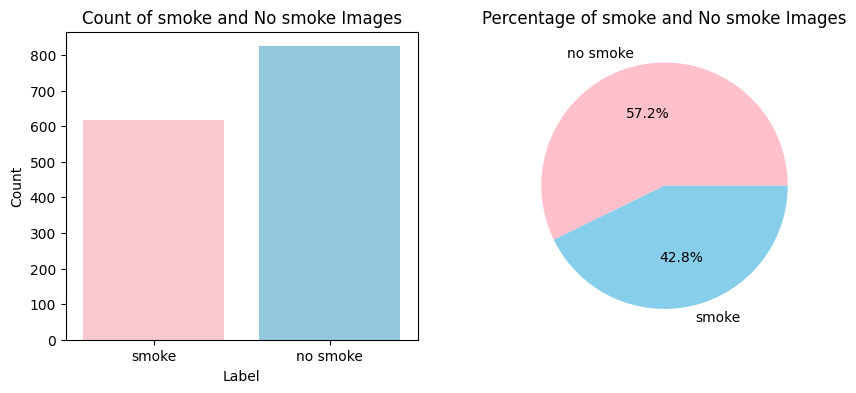

In [ ]:
# plotting visualisation

plt.figure(figsize=(10, 4))

# Bar Plot
plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df, palette=['pink', 'skyblue'])
plt.title('Count of smoke and No smoke Images')
plt.xlabel('Label')
plt.ylabel('Count')

# Pie Chart
plt.subplot(1, 2, 2)
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index, autopct='%1.1f%%', colors=['pink', 'skyblue'])
plt.title('Percentage of smoke and No smoke Images')

plt.show()



The below code selects and displays a set of sample images labeled as 'fire' from the DataFrame.
 This visual representation allows for a quick inspection of sample images in the 'fire' category for qualitative assessment and understanding of the dataset.
 The display of sample images can reveal variations in image sizes, structures, and content, helping to assess the diversity and complexity of the dataset. This visual inspection is valuable for practitioners in tasks like image classification, as it allows them to get a sense of the data distribution, potential challenges, and the need for preprocessing steps such as resizing images to a consistent size for model training.

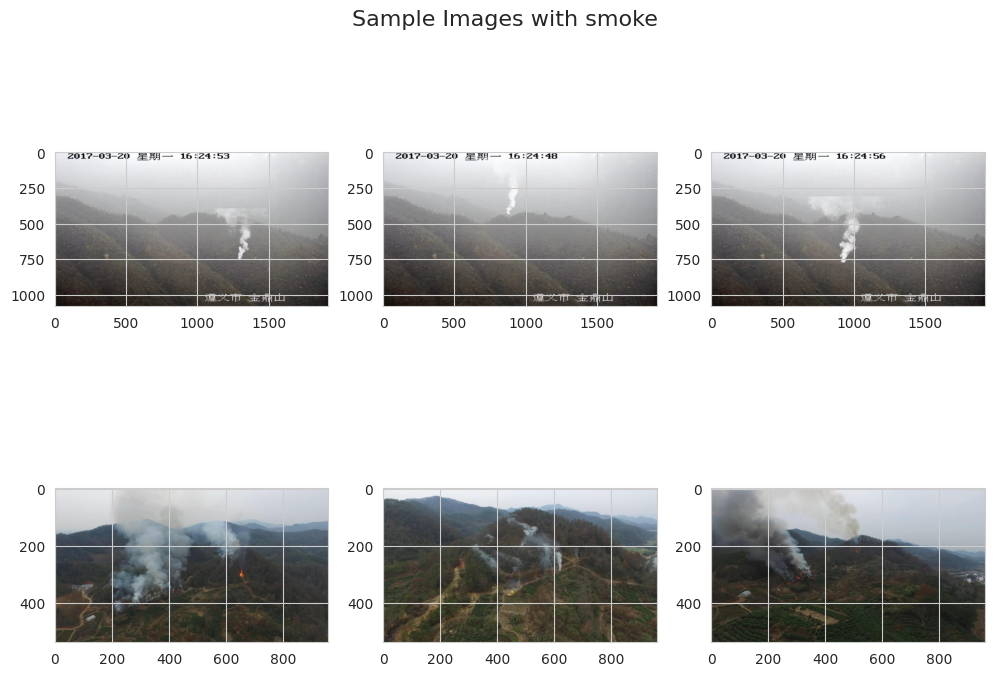

In [ ]:
# Setting the label for which images will be displayed (smoke in this case)
label = 'smoke'

# Filtering the DataFrame to get rows with the specified label
data = df[df['label'] == label]

#style for seaborn plots
sns.set_style('whitegrid')

#number of images to display
pics = 6

# Creating subplots for displaying sample images with fire
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
plt.suptitle('Sample Images with smoke', fontsize=16)

# Flattening the axes array for easy iteration
ax = ax.ravel()

# Iterate through the specified number of images
for i in range(pics):
    # Select a random path from the filtered data
    path = data.sample(1).loc[:, 'path'].to_numpy()[0]

    # Loading and displaying the image using matplotlib
    img = image.load_img(path)
    img = image.img_to_array(img) / 255
    ax[i].imshow(img)

# Displaying the sample images with smoke
plt.show()

In [ ]:
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(df, train_size=0.8, random_state=46)

# Display the first few rows of the training set DataFrame
display(train_df.head())

# Display the first few rows of the testing set DataFrame
test_df.head()

,path,label
546,/content/drive/My Drive/code/nosmoke/nofire_07...,no smoke
1266,/content/drive/My Drive/code/smoke/Smoke (817)...,smoke
494,/content/drive/My Drive/code/nosmoke/nf2 (282)...,no smoke
393,/content/drive/My Drive/code/nosmoke/nofire_03...,no smoke
596,/content/drive/My Drive/code/nosmoke/nf2 (394)...,no smoke


,path,label
785,/content/drive/My Drive/code/smoke/Smoke (138)...,smoke
172,/content/drive/My Drive/code/nosmoke/nf1 (241)...,no smoke
158,/content/drive/My Drive/code/smoke/Smoke (458)...,smoke
1144,/content/drive/My Drive/code/smoke/Smoke (618)...,smoke
1163,/content/drive/My Drive/code/smoke/Smoke (49).jpg,smoke


This code sets up an image data generator with various augmentation techniques. Augmentation involves applying random transformations to the training images, such as rotation, width and height shifts, shear, and zoom. These transformations help diversify the training dataset, making the model more robust and better at generalizing to different variations in the input images. The rescale parameter normalizes pixel values to the range [0, 1], and validation_split reserves a portion of the data for validation during training to assess the model's performance on unseen data.

In [ ]:
# Creating an ImageDataGenerator for data augmentation during training
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to the range [0, 1]
    shear_range=0.2,               #  apply shearing transformation
    zoom_range=0.1,                #  zoom in on images
    rotation_range=20,             #  rotate images within the given range
    width_shift_range=0.1,         #  shift images horizontally
    height_shift_range=0.1,        #  shift images vertically
    horizontal_flip=True,          #  flip images horizontally
    vertical_flip=True,            #  flip images vertically
    validation_split=0.2           # Fraction of training data to use for validation
)

# Creating an ImageDataGenerator for normalizing pixel values during testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Displaying a message indicating the preparation of the training dataset
print("Preparing the training dataset")

# Generating batches of augmented data for training using the training dataset
training_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,            # Training DataFrame
    x_col="path",                   # Column containing image file paths
    y_col="label",                  # Column containing class labels
    target_size=(250, 250),          # Target size for resizing images
    color_mode="rgb",               # Color mode for images (RGB)
    class_mode="binary",            # Type of class labels (binary for binary classification)
    batch_size=32,                   # Number of samples in each batch
    shuffle=True,                   # Shuffle the data
    seed=1,                         # Random seed for reproducibility
    subset="training"               # Indicate that this is the training subset
)

# Displaying a message indicating the preparation of the validation dataset
print("Preparing the validation dataset")

# Generating batches of augmented data for validation using the training dataset
validation_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col="label",
    target_size=(250, 250),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1,
    subset="validation"             # Indicate that this is the validation subset
)

# Displaying a message indicating the preparation of the test dataset
print("Preparing the test dataset")

# Generating batches of data for testing using the testing dataset
test_set = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=(250, 250),
    color_mode="rgb",
    class_mode="binary",
    shuffle=False,                  # Do not shuffle the test data
    batch_size=32
)


Preparing the training dataset
Found 922 validated image filenames belonging to 2 classes.
Preparing the validation dataset
Found 230 validated image filenames belonging to 2 classes.
Preparing the test dataset
Found 288 validated image filenames belonging to 2 classes.


This below code is creating a mapping dictionary (class_indices) that associates numerical labels with their corresponding class names. It's useful for interpreting the numerical labels assigned to classes by the training data generator. The printed output shows the mapping between numerical labels and class names.

### Visualizing the generated images in training set

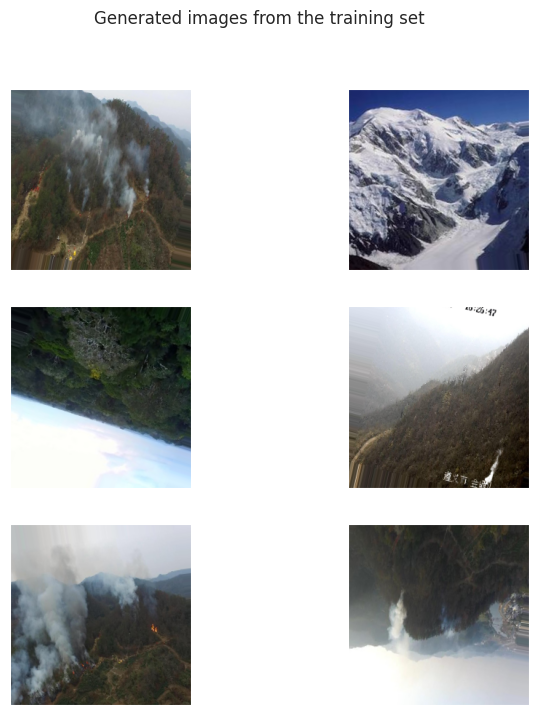

In [ ]:
sns.set_style('darkgrid')  # Set the style of the seaborn plots
pics = 6  # set the number of pics
fig, axes = plt.subplots(int(pics // 2), 2, figsize=(8, 8)) # Create subplots with the specified layout
plt.suptitle('Generated images from the training set')
axes = axes.ravel() # Flatten the axes for easier iteration

# axes to display generated images
for i, ax in enumerate(axes):
    ax.imshow(training_set[0][0][i]) # Display the ith generated image from the training set
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


In [ ]:
def PreprocessingImage(img_path, target_size=(250, 250)):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not read image at path: {img_path}")
    if 'fire' in img_path:
        img = highlight_smoke(img_path)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # for Normalising the image
    return img

In [ ]:
# Data Preparation for ML models
def DataProcessing(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        imagepath = row['path']
        label = 1 if row['label'] == 'smoke' else 0
        image = PreprocessingImage(imagepath, target_size=(64, 64))
        images.append(image.flatten())
        labels.append(label)
    X = np.array(images)
    y = np.array(labels)
    return X, y

In [ ]:
# splitting data into training and testing sets
X_train, y_train = DataProcessing(train_df)
X_test, y_test = DataProcessing(test_df)

In [ ]:
# Random Forest
RandomForestModel = RandomForestClassifier()
RandomForestModel.fit(X_train, y_train)
yPred_RandomForest = RandomForestModel.predict(X_test)
print("Random Forest Accuracy: {:.2f}%".format(precision_score(y_test, yPred_RandomForest)*100))

Random Forest Accuracy: 98.39%


In [ ]:
# Support Vector Machine
SupportVectorMachines = make_pipeline(StandardScaler(), SVC(probability=True))
SupportVectorMachines.fit(X_train, y_train)
yPred_SupportVectorMachines = SupportVectorMachines.predict(X_test)
print("Support Vector Machines Accuracy: {:.2f}%".format(precision_score(y_test, yPred_SupportVectorMachines)*100))

Support Vector Machines Accuracy: 96.83%


In [ ]:
# K-Nearest Neighbors
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
yPred_KNN = KNN.predict(X_test)
print("KNN Accuracy: {:.2f}%".format(precision_score(y_test, yPred_KNN)*100))

KNN Accuracy: 85.31%


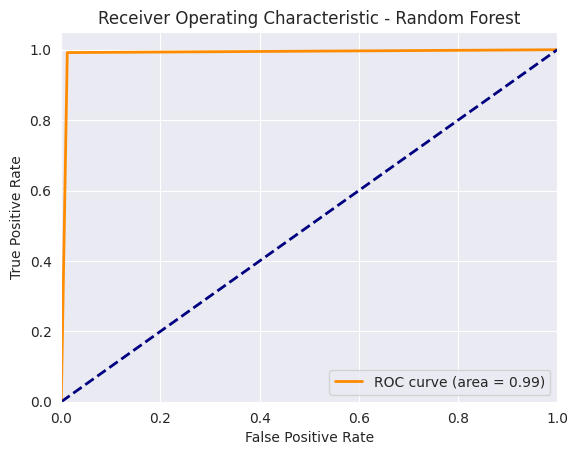

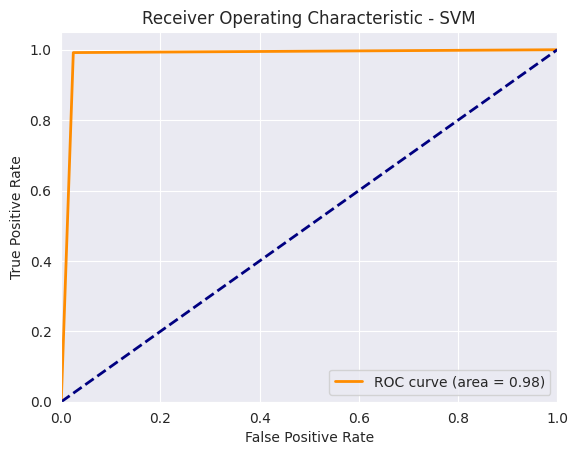

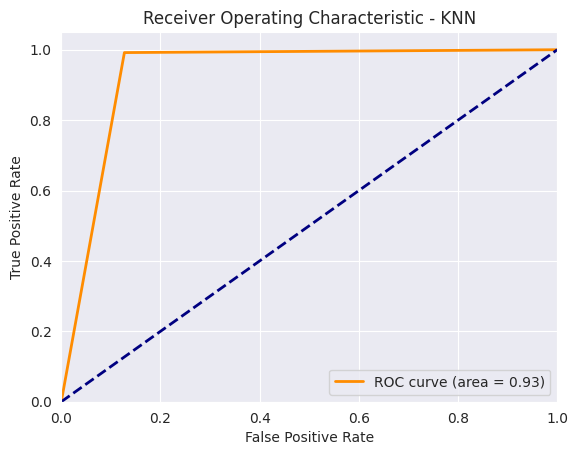

In [ ]:
# Definining Function for Plotting ROC Curve
def PlottingROCurve(y_test, y_pred, ModelName):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {ModelName}')
    plt.legend(loc="lower right")
    plt.show()

PlottingROCurve(y_test, yPred_RandomForest, 'Random Forest')
PlottingROCurve(y_test, yPred_SupportVectorMachines, 'SVM')
PlottingROCurve(y_test, yPred_KNN, 'KNN')

                                                     path     label
count                                                1440      1440
unique                                               1440         2
top     /content/drive/My Drive/code/smoke/Smoke (52).jpg  no smoke
freq                                                    1       824


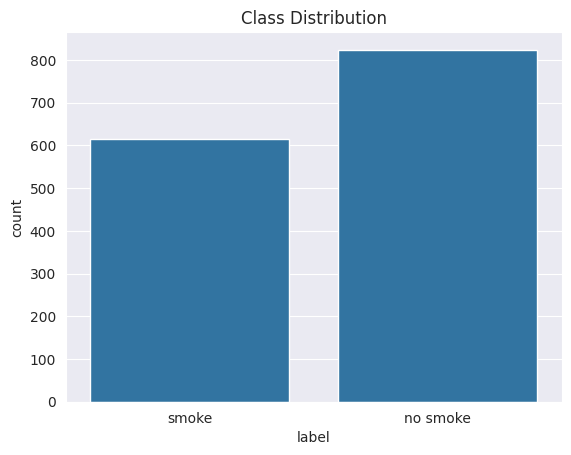

In [ ]:
# Descriptive Statistics
print(dataframe.describe())

# Class Distribution
sns.countplot(x='label', data=dataframe)
plt.title('Class Distribution')
plt.show()

# Creating the model

In [ ]:
# Defining a function for building the CNN model
def BuildingModel(Inputshape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=Inputshape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(SpatialDropout2D(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(SpatialDropout2D(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(units=1, activation='sigmoid'))
    callbacks = [EarlyStopping(monitor='loss', mode='min', patience=20, restore_best_weights=True)]
    return model, callbacks

# Defining a function for compiling the model
def CompilingModel(model, LearningRate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=LearningRate)
    model.compile(
        optimizer=optimizer,          # Adam optimizer
        loss='binary_crossentropy',   # Binary crossentropy loss
        metrics=['accuracy']          # accuracy during training
    )

# Defining a function for training the model
def TrainingModel(model, TrainingSet, ValidationSet, BatchSize=32, epochs=15):
    history = model.fit(
        TrainingSet,                    # Training data generator
        batch_size=BatchSize,           # Number of samples in each batch
        epochs=epochs,                   # Number of training epochs
        validation_data=ValidationSet,  # Validation data generator
        callbacks=callbacks              # Callbacks for early stopping
    )
    return history

# Defining a function for the evaluation of model
def EvaluatingModel(model, TestSet):
    score = model.evaluate(TestSet)
    print("Test Loss:", score[0])
    print("Test Accuracy:", score[1])

In [ ]:
# Defining the input shape
InputShape = (250, 250, 3)

# Defining Total output classes
TotalClasses = 1

# Create the model and callbacks using the build_model function
model, callbacks = BuildingModel(InputShape)

# Display a summary of the model architecture, including layer details and parameters
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 spatial_dropout2d (Spatial  (None, 59, 59, 64)        0

In [ ]:
#compile model
learning_rate = 0.001
CompilingModel(model,learning_rate)

#Train model
batch_size = 32
epochs=10
history = TrainingModel(model,training_set,validation_set,batch_size,epochs)

#evalute model
EvaluatingModel(model,test_set)

Epoch 1/10
29/29 [==============================] - 41s 1s/step - loss: 0.5720 - accuracy: 0.6573 - val_loss: 0.2915 - val_accuracy: 0.9043
Epoch 2/10
29/29 [==============================] - 30s 1s/step - loss: 0.2870 - accuracy: 0.8948 - val_loss: 0.1969 - val_accuracy: 0.9304
Epoch 3/10
29/29 [==============================] - 28s 956ms/step - loss: 0.2288 - accuracy: 0.9046 - val_loss: 0.1896 - val_accuracy: 0.9043
Epoch 4/10
29/29 [==============================] - 31s 1s/step - loss: 0.1731 - accuracy: 0.9349 - val_loss: 0.0878 - val_accuracy: 0.9696
Epoch 5/10
29/29 [==============================] - 27s 922ms/step - loss: 0.1363 - accuracy: 0.9631 - val_loss: 0.1332 - val_accuracy: 0.9565
Epoch 6/10
29/29 [==============================] - 31s 1s/step - loss: 0.1573 - accuracy: 0.9447 - val_loss: 0.1131 - val_accuracy: 0.9652
Epoch 7/10
29/29 [==============================] - 27s 957ms/step - loss: 0.1357 - accuracy: 0.9479 - val_loss: 0.0978 - val_accuracy: 0.9739
Epoch 8/10


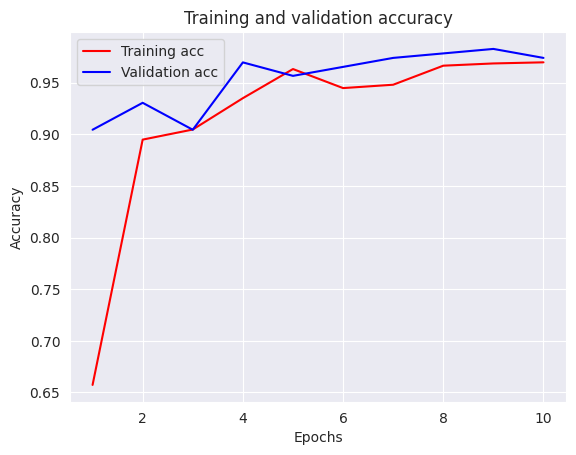

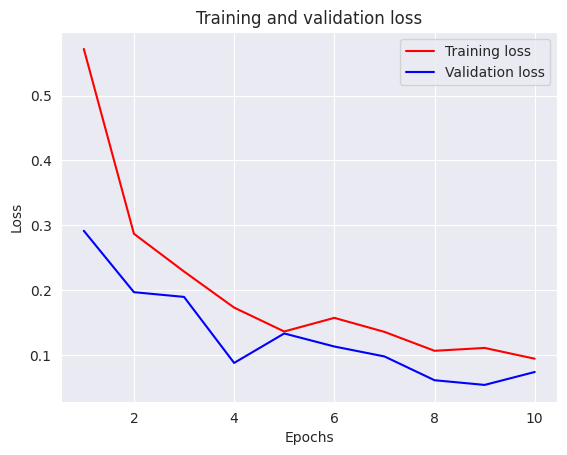

In [ ]:
# Extracting training and validation accuracy, loss, and epochs from the training history
AccuracyOfModel = history.history['accuracy']
ValidationAccuracy = history.history['val_accuracy']
loss = history.history['loss']
ValidityLoss = history.history['val_loss']
epochs = range(1, len(AccuracyOfModel) + 1)

# Plotting training and validation accuracy over epochs
plt.title('Training and validation accuracy')
plt.plot(epochs, AccuracyOfModel, 'red', label='Training acc')
plt.plot(epochs, ValidationAccuracy, 'blue', label='Validation acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plotting training and validation loss over epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, ValidityLoss, 'blue', label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Getting predictions
y_pred = model.predict(test_set)

# Rounding the predicted probabilities
y_pred = np.round(y_pred)

9/9 [==============================] - 3s 346ms/step


In [ ]:
# printing the CNN Accuracy
print("CNN Accuracy: {:.2f}%".format(precision_score(test_set.classes, y_pred)*100))

CNN Accuracy: 96.06%



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       165
           1       0.96      0.99      0.98       123

    accuracy                           0.98       288
   macro avg       0.98      0.98      0.98       288
weighted avg       0.98      0.98      0.98       288



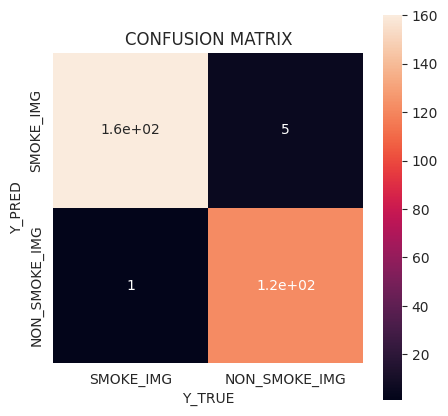

In [ ]:
# Getting true labels
y_true = test_set.classes

# Creating confusion matrix
ConfusionMatrix = confusion_matrix(y_true, y_pred)

# Printing the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

plt.figure(figsize=(5,5))
sns.heatmap(ConfusionMatrix, square=True, annot=True,
            yticklabels=['SMOKE_IMG', 'NON_SMOKE_IMG'],
            xticklabels=['SMOKE_IMG', 'NON_SMOKE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("Y_PRED");

In [ ]:
# #Fine Tuning
# ##compile model
# learning_rate = 0.03
# CompilingModel(model,learning_rate)

# #Train model260
# batch_size = 16
# epochs=20
# history = TrainingModel(model,training_set,validation_set,batch_size,epochs)

# #evalute model
# EvaluatingModel(model,test_set)

In [ ]:
# #Defining a function for applying preprocessing
# def PreprocessingImage(img_path, target_size=(250, 250)):
#     img = cv2.imread(img_path)
#     if img is None:
#         raise ValueError(f"Could not read image at path: {img_path}")
#     if 'fire' in img_path:
#         img = highlight_smoke(img_path)
#     img = cv2.resize(img, target_size)
#     img = img / 255.0  # for Normalising the image
#     return img

def predictImage(img_path, target_size=(250, 250)):
    img = PreprocessingImage(img_path, target_size=target_size)
    img_array = np.expand_dims(img, axis=0)
    prediction = model.predict(img_array)
    val = np.round(prediction).astype(int)
    if val == 0:
        result = 'no fire'
    elif val == 1:
        result = 'fire'
    plt.imshow(cv2.imread(img_path))  # for Displaying original image
    plt.title(f'Prediction: {result}')
    plt.axis('off')
    plt.show()

    return result

1/1 [==============================] - 0s 300ms/step


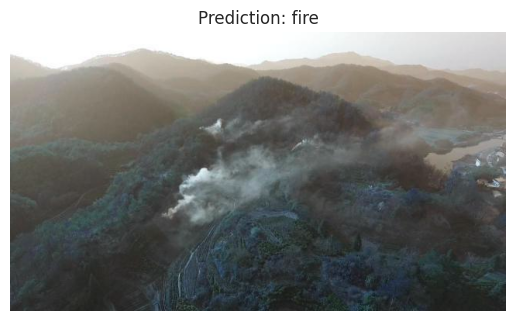

'fire'

In [ ]:
# Predicting an image
img_path = '/content/drive/My Drive/code/smoke/Smoke (97).jpg'
predictImage(img_path)

1/1 [==============================] - 0s 31ms/step


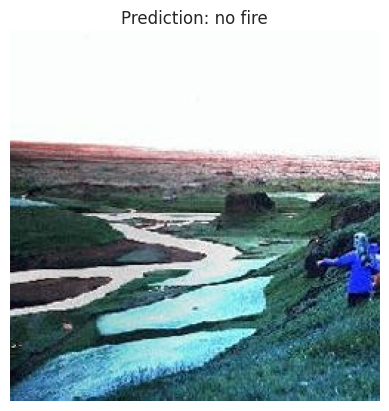

'no fire'

In [ ]:
# Predicting an image
img_path = '/content/drive/My Drive/code/nosmoke/nofire_0715.jpg'
predictImage(img_path)

1/1 [==============================] - 0s 18ms/step


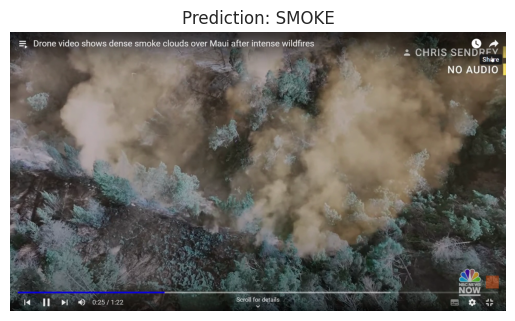

Prediction: SMOKE


In [ ]:
import cv2
import numpy as np
import random
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Assuming the highlight_smoke function is defined somewhere in your codebase
def highlight_smoke(img_path):
    # Dummy implementation, replace with actual logic
    return cv2.imread(img_path)

# Defining a function for applying preprocessing to a frame
def PreprocessingFrame(frame, target_size=(250, 250)):
    img = frame
    img = cv2.resize(img, target_size)
    img = img / 255.0  # for Normalising the image
    return img

# Predict function adapted for frame input
def predictFrame(model, frame, target_size=(250, 250)):
    img = PreprocessingFrame(frame, target_size=target_size)
    img_array = np.expand_dims(img, axis=0)
    prediction = model.predict(img_array)
    val = np.round(prediction).astype(int)
    if val == 0:
        result = 'NO SMOKE'
    elif val == 1:
        result = 'SMOKE'
    plt.imshow(frame)  # for Displaying the original frame
    plt.title(f'Prediction: {result}')
    plt.axis('off')
    plt.show()

    return result

def extract_frames_from_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frames = []

    # Check if video opened successfully
    if not cap.isOpened():
        print("Error opening video stream or file")
        return frames

    # Read until the video is completed
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            # Append the frame to the list
            frames.append(frame)
        else:
            break

    # When everything done, release the video capture object
    cap.release()
    cv2.destroyAllWindows()

    return frames

def main(video_path, model_path):

    # Extract frames from the video
    frames = extract_frames_from_video(video_path)

    if not frames:
        print("No frames extracted from the video.")
        return

    # Select a random frame
    random_frame = random.choice(frames)

    # Predict if the selected frame contains smoke or no smoke
    prediction = predictFrame(model, random_frame)
    print(f'Prediction: {prediction}')


video_path = '/content/drive/My Drive/code/video.mp4'  # Replace with the path to your video file
model_path = model   # Replace with the path to your trained model file
main(video_path, model_path)


1/1 [==============================] - 0s 18ms/step


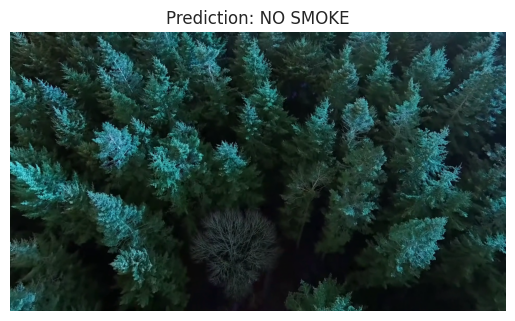

Prediction: NO SMOKE


In [ ]:
video_path = '/content/drive/My Drive/code/no_smoke_video.mp4'  # Replace with the path to your video file
model_path = model   # Replace with the path to your trained model file
main(video_path, model_path)

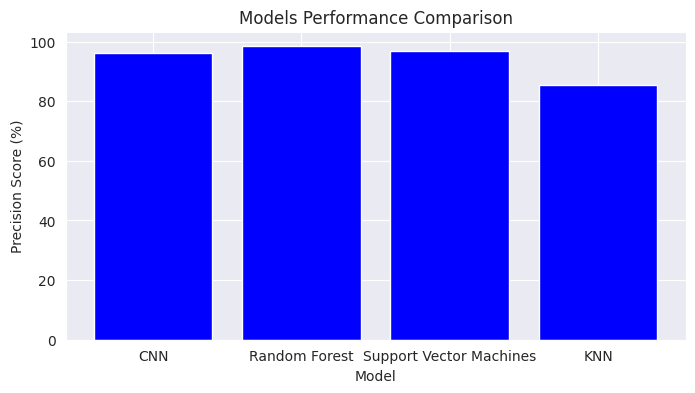

In [ ]:
# Visualising all model's performance
Models = ["CNN", "Random Forest", "Support Vector Machines", "KNN"]
Accuracies = [precision_score(test_set.classes, y_pred)*100,
             precision_score(y_test, yPred_RandomForest)*100,
             precision_score(y_test, yPred_SupportVectorMachines)*100,
             precision_score(y_test, yPred_KNN)*100]

x = range(len(Models))
y = Accuracies

plt.figure(figsize=(8, 4))
plt.bar(x, y, color="blue")
plt.xticks(x, Models)
plt.xlabel("Model")
plt.ylabel("Precision Score (%)")
plt.title("Models Performance Comparison")
plt.show()